In [1]:
import os
if os.name=='nt':
    mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
    os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sys import getsizeof
import time

%matplotlib inline

/home/li/miniconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import pickle

def save_pickle(x, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_pickle(filename):
    with open(filename, 'rb') as handle:
        x = pickle.load(handle)
    return x

In [3]:
x_train0 = read_pickle('x_train_date_feats_0.pickle')
x_test = read_pickle('x_test_date_feats_0.pickle')

In [4]:
y_train0 = pd.read_csv('data/train_numeric.csv.zip', index_col=0, usecols=[0, 969])

/home/li/miniconda3/envs/kaggle/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
y_train0 = y_train0.values.ravel()

In [6]:
n_estimators = 400
clf = XGBClassifier(max_depth=14, n_estimators=n_estimators, base_score=0.0058, n_jobs=8, colsample_bytree=0.6,
                   min_child_weight=5, subsample=0.9,  reg_lambda=4, silent=False, learning_rate=0.03)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train0, y_train0, test_size=0.2, random_state=0)

cv = StratifiedKFold(y_train, n_folds=5, shuffle=True, random_state=0)

preds = np.ones(y_train.shape[0])
for i, (train, test) in enumerate(cv):
    clf.fit(x_train[train], y_train[train], 
                          eval_set=[(x_val, y_val)], eval_metric='auc', 
                          early_stopping_rounds=10)
    models.append(clf)
    preds[test] = clf.predict_proba(x_train[test])[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y_train[test], preds[test])))
print(roc_auc_score(y_train, preds))

In [8]:
clf.fit(x_train, y_train, eval_set=[(x_val, y_val)], eval_metric='auc', early_stopping_rounds=10)

[0]	validation_0-auc:0.899906
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.903168
[2]	validation_0-auc:0.904874
[3]	validation_0-auc:0.906514
[4]	validation_0-auc:0.906739
[5]	validation_0-auc:0.907584
[6]	validation_0-auc:0.90761
[7]	validation_0-auc:0.90887
[8]	validation_0-auc:0.909282
[9]	validation_0-auc:0.909709
[10]	validation_0-auc:0.91008
[11]	validation_0-auc:0.910309
[12]	validation_0-auc:0.911002
[13]	validation_0-auc:0.911195
[14]	validation_0-auc:0.911674
[15]	validation_0-auc:0.91245
[16]	validation_0-auc:0.912231
[17]	validation_0-auc:0.912312
[18]	validation_0-auc:0.912421
[19]	validation_0-auc:0.912445
[20]	validation_0-auc:0.91249
[21]	validation_0-auc:0.912505
[22]	validation_0-auc:0.912538
[23]	validation_0-auc:0.912424
[24]	validation_0-auc:0.912562
[25]	validation_0-auc:0.912762
[26]	validation_0-auc:0.913011
[27]	validation_0-auc:0.912999
[28]	validation_0-auc:0.913269
[29]	validation_0-auc:0.913505
[30]	validation_0-auc

XGBClassifier(base_score=0.0058, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=14, min_child_weight=5, missing=None, n_estimators=400,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=4, scale_pos_weight=1, seed=None,
       silent=False, subsample=0.9)

In [12]:
if clf.best_ntree_limit:
    n_estimators = int(clf.best_ntree_limit * 1.2)

clf.n_estimators = n_estimators

In [13]:
n_estimators

75

In [15]:
clf.fit(x_train0, y_train0, eval_set=[(x_train0, y_train0)], eval_metric='auc')

[0]	validation_0-auc:0.914406
[1]	validation_0-auc:0.919529
[2]	validation_0-auc:0.924183
[3]	validation_0-auc:0.92736
[4]	validation_0-auc:0.928957
[5]	validation_0-auc:0.930066
[6]	validation_0-auc:0.930779
[7]	validation_0-auc:0.931674
[8]	validation_0-auc:0.932192
[9]	validation_0-auc:0.932589
[10]	validation_0-auc:0.932887
[11]	validation_0-auc:0.933132
[12]	validation_0-auc:0.934319
[13]	validation_0-auc:0.934464
[14]	validation_0-auc:0.934629
[15]	validation_0-auc:0.93512
[16]	validation_0-auc:0.935177
[17]	validation_0-auc:0.936828
[18]	validation_0-auc:0.937576
[19]	validation_0-auc:0.93877
[20]	validation_0-auc:0.939004
[21]	validation_0-auc:0.939757
[22]	validation_0-auc:0.939941
[23]	validation_0-auc:0.940283
[24]	validation_0-auc:0.940562
[25]	validation_0-auc:0.941295
[26]	validation_0-auc:0.941605
[27]	validation_0-auc:0.941951
[28]	validation_0-auc:0.942517
[29]	validation_0-auc:0.942549
[30]	validation_0-auc:0.943067
[31]	validation_0-auc:0.943438
[32]	validation_0-auc

XGBClassifier(base_score=0.0058, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=14, min_child_weight=5, missing=None, n_estimators=75,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=4, scale_pos_weight=1, seed=None,
       silent=False, subsample=0.9)

In [23]:
preds = clf.predict_proba(x_train0)
preds = preds[:, 1]

/home/li/miniconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.4782430045488553


Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f42dd9264a8>>
Traceback (most recent call last):
  File "/home/li/xgboost/python-package/xgboost/core.py", line 369, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


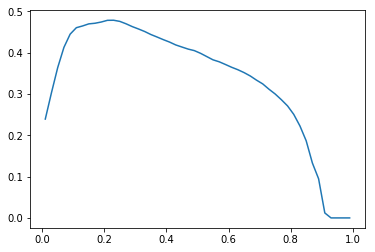

In [24]:
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y_train0, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [25]:
preds = (clf.predict_proba(x_test)[:, 1]>best_threshold).astype(np.int8)
sub = pd.read_csv('data/sample_submission.csv.zip', index_col=0)
sub['Response'] = preds
sub.to_csv('submission_train_time_features.csv.gz', compression='gzip')

/home/li/miniconda3/envs/kaggle/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
